## 相似视频检索

这一步只能计算得到关键帧相似结果，但具体的视频时间段还需要进一步对齐（TODO）。

In [4]:
import glob
import pandas as pd
import pickle

PATH = '/home/wx/work/video_copy_detection/'
TRAIN_PATH = PATH + 'train/'
TEST_PATH = PATH + 'test/'
QUERY_PATH = TRAIN_PATH + 'query/'
REFER_PATH = TRAIN_PATH + 'refer/'
QUERY_FRAME_PATH = TRAIN_PATH + 'query_frame/'
REFER_FRAME_PATH = TRAIN_PATH + 'refer_frame/'
TEST_QUERY_PATH = TEST_PATH + 'query/'
TEST_QUERY_FRAME_PATH = TEST_PATH + 'query_frame/'
CODE_DIR = PATH + 'code/'

In [5]:
# 读取特征文件

with open(PATH + 'var/test_query_features.txt', 'rb') as f:
    test_query_features = pickle.load(f)

with open(PATH + 'var/refer_features.txt', 'rb') as f:
    refer_features = pickle.load(f)

In [6]:
# 读取 query 视频的关键帧，并按照视频和关键帧时间进行排序
query_imgs_path = []
for id in pd.read_csv(TEST_PATH + 'submit_example.csv')['query_id']:
    query_imgs_path += glob.glob(TEST_QUERY_FRAME_PATH + id + '/*.jpg')

query_imgs_path.sort(key = lambda x: x.lower())

In [7]:
# 读取refer视频的关键帧，并按照视频和关键帧时间进行排序

refer_imgs_path = glob.glob(REFER_FRAME_PATH + '*/*.jpg')
refer_imgs_path.sort(key = lambda x: x.lower())

In [8]:
import cv2
import imagehash
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook
from scipy.spatial.distance import cosine

def compute_cosin_distance(Q, feats, names):
    """
    feats and Q: L2-normalize, n*d
    """
    dists = np.dot(Q, feats.T)
    idxs = np.argsort(dists)[::-1]
    rank_dists = dists[idxs]
    rank_names = [names[k] for k in idxs]
    return idxs, rank_dists, rank_names

def hamming_distance(chaine1, chaine2):
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))

In [9]:
path_flag = [0]
threshold = 0.9
for idx, (path, feat) in enumerate(zip(query_imgs_path, test_query_features)):
    idxs, rank_dists, rank_names = compute_cosin_distance(feat, refer_features, refer_imgs_path)
    if rank_dists[0] > threshold:
        # if hamming_distance(refer_hash[idxs[0]], query_hash[idx]) < 5:
        
        if path.split('/')[-2] != path_flag[-1]:
            print('')
        
        print(path.split('/')[-1], rank_names[0].split('/')[-1])
        path_flag.append(path.split('/')[-2])


016cf7e8-b8d6-11e9-930e-fa163ee49799_00000000.000000080.300000.jpg 1293733400_00000169.200000038.520000.jpg
016cf7e8-b8d6-11e9-930e-fa163ee49799_00000000.500000068.700000.jpg 1293733400_00000817.600000555.560000.jpg
016cf7e8-b8d6-11e9-930e-fa163ee49799_00000074.700000019.400000.jpg 1293733400_00000837.700000376.720000.jpg

03031510-b8d1-11e9-930e-fa163ee49799_00000023.400000030.700000.jpg 1260706600_00002520.400001670.640000.jpg
03031510-b8d1-11e9-930e-fa163ee49799_00000025.500000007.500000.jpg 1260706600_00001814.600000737.000000.jpg
03031510-b8d1-11e9-930e-fa163ee49799_00000048.900000038.600000.jpg 1260706600_00003669.300003674.720000.jpg

0367233c-b874-11e9-b45b-fa163ee49799_00000081.600000052.133333.jpg 2801578300_00002821.900002483.960000.jpg

041134d8-b989-11e9-b8ed-fa163e063a2b_00000059.300000145.666667.jpg 1502559900_00001664.800007359.200000.jpg

07b833d0-b910-11e9-81a2-fa163e3d9e3c_00000078.800000041.400000.jpg 1773350800_00001237.100000562.560000.jpg
07b833d0-b910-11e9-81a2

KeyboardInterrupt: 

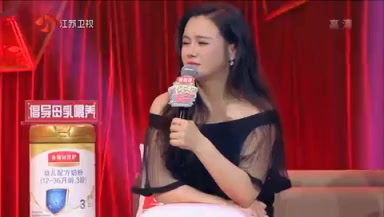

In [11]:
Image.open(TEST_QUERY_FRAME_PATH + '016cf7e8-b8d6-11e9-930e-fa163ee49799/016cf7e8-b8d6-11e9-930e-fa163ee49799_00000000.000000080.300000.jpg')

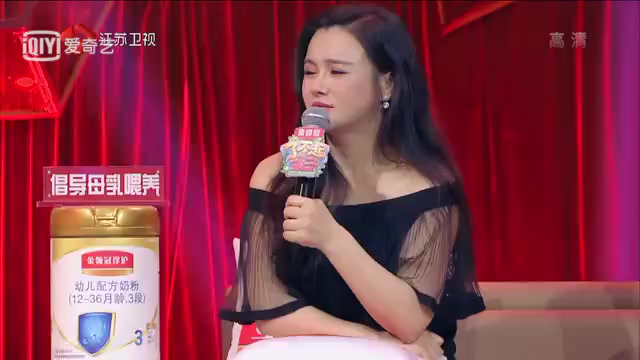

In [12]:
Image.open(REFER_FRAME_PATH + '1293733400/1293733400_00000169.200000038.520000.jpg')

In [14]:
# 提交一个最简单的结果

submit_df = pd.read_csv(TEST_PATH + 'submit_example.csv')
submit_df.loc[submit_df['query_id'] == '016cf7e8-b8d6-11e9-930e-fa163ee49799', 
              ['query_time_range(ms)', 'refer_id', 'refer_time_range(ms)']] = ['0|80500', '1293733400', '554000|635000']
submit_df.to_csv('result.csv', index = None, sep=',')